# Dimensionality reduction and clustering

We will take both the full dataset without correction, and the dataset after MNN correction and run PCA, tSNE, UMAP, Diffusion Maps on to compare the output.  

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()


scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

Read the data from batch correction.


In [3]:
cdata = sc.read_h5ad('./../write/scanpy/mnn_corrected_3pbmc.h5ad')
adata = sc.read_h5ad('./../write/scanpy/uncorrected_3pbmc.h5ad')


In [4]:
adata

AnnData object with n_obs × n_vars = 2530 × 2330 
    obs: 'batch', 'lib_prep', 'n_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'lib_prep_colors'

In [5]:
cdata

AnnData object with n_obs × n_vars = 2530 × 1968 
    obs: 'G2M_score', 'S_score', 'batch', 'lib_prep', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

First run PCA for the uncorrected dataset

In [6]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

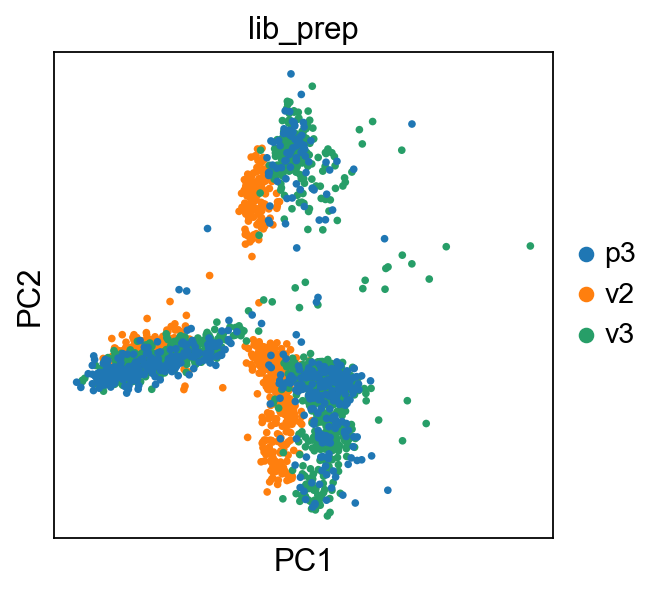

In [7]:
sc.pl.pca(adata, color='lib_prep')

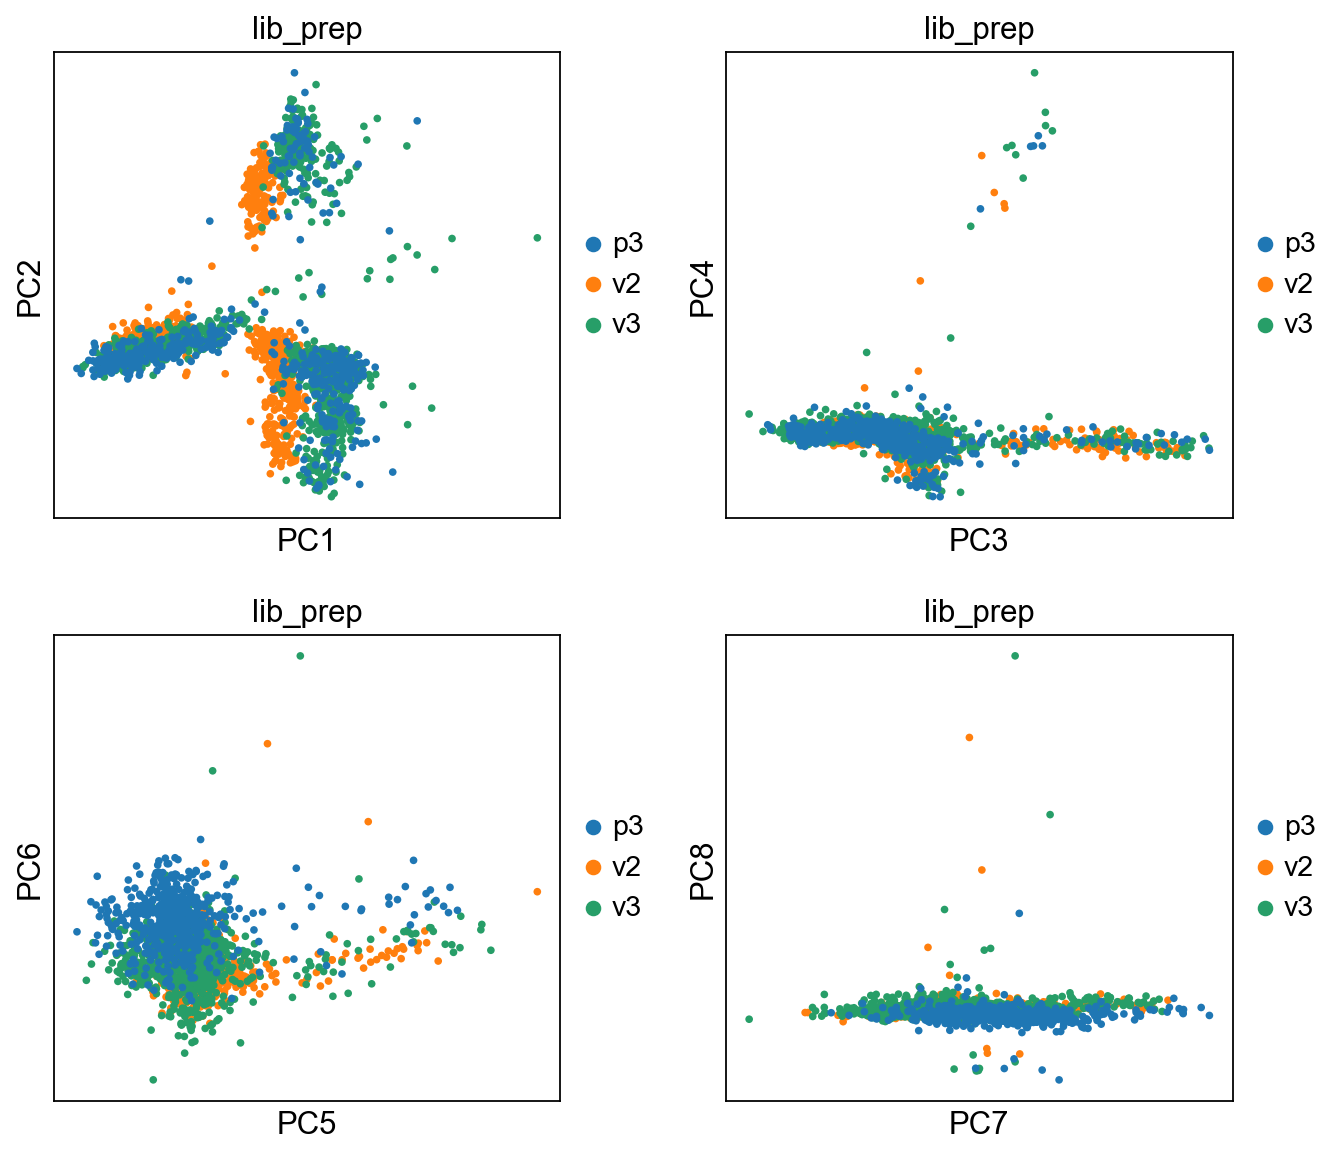

In [8]:
# plot more PCS

sc.pl.pca(adata, color='lib_prep', components = ['1,2','3,4','5,6','7,8'], ncols=2)


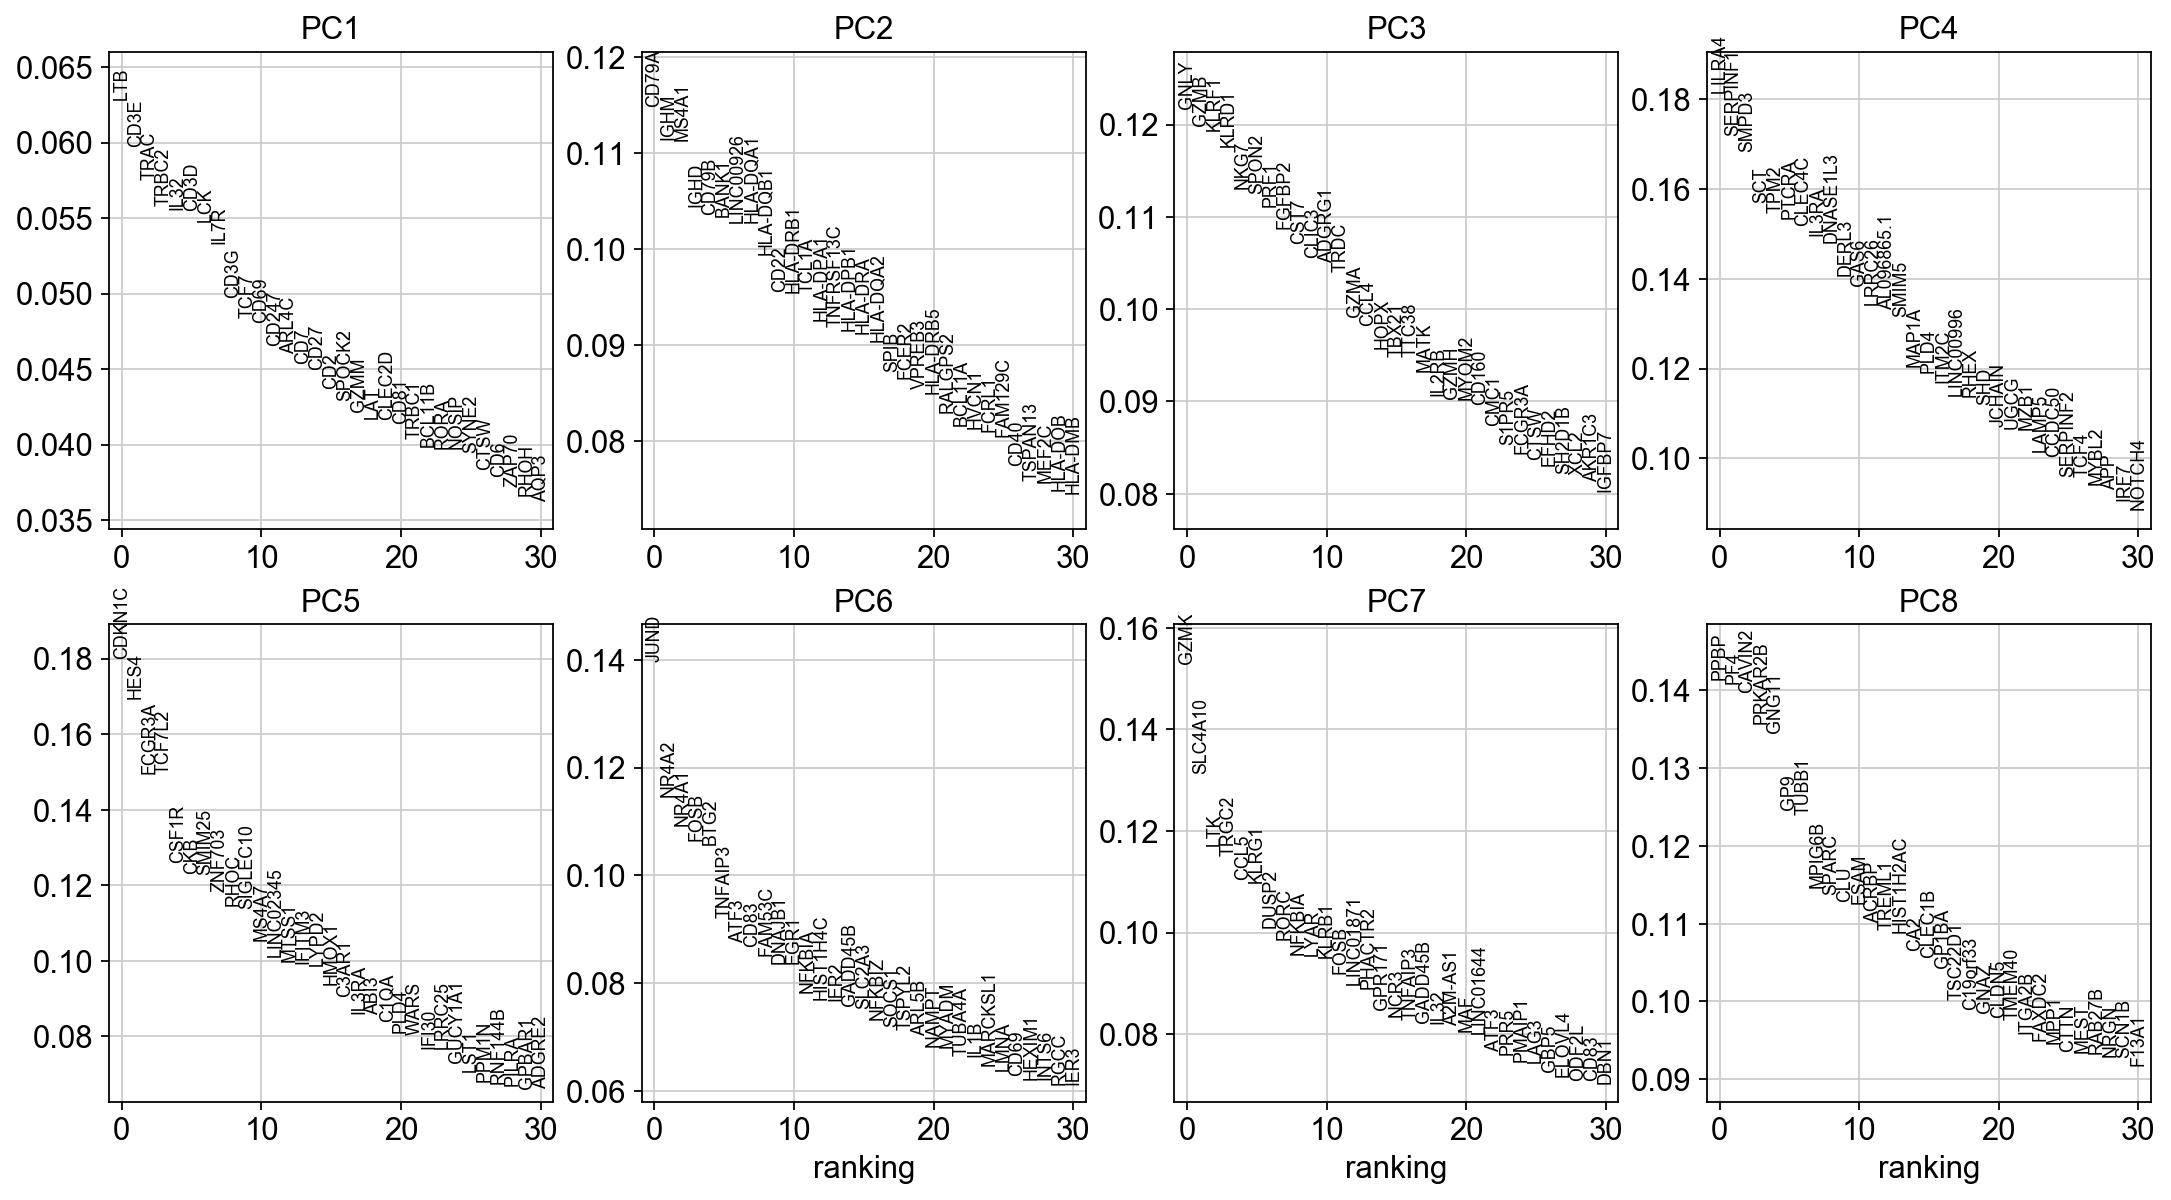

In [9]:
#Plot loadings
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

# OBS! only plots the positive axes genes from each PC!!


The function to plot loading genes only plots genes on the positive axes. Instead plot as a heatmaps, with genes on both postive and negative side, one per pc. 

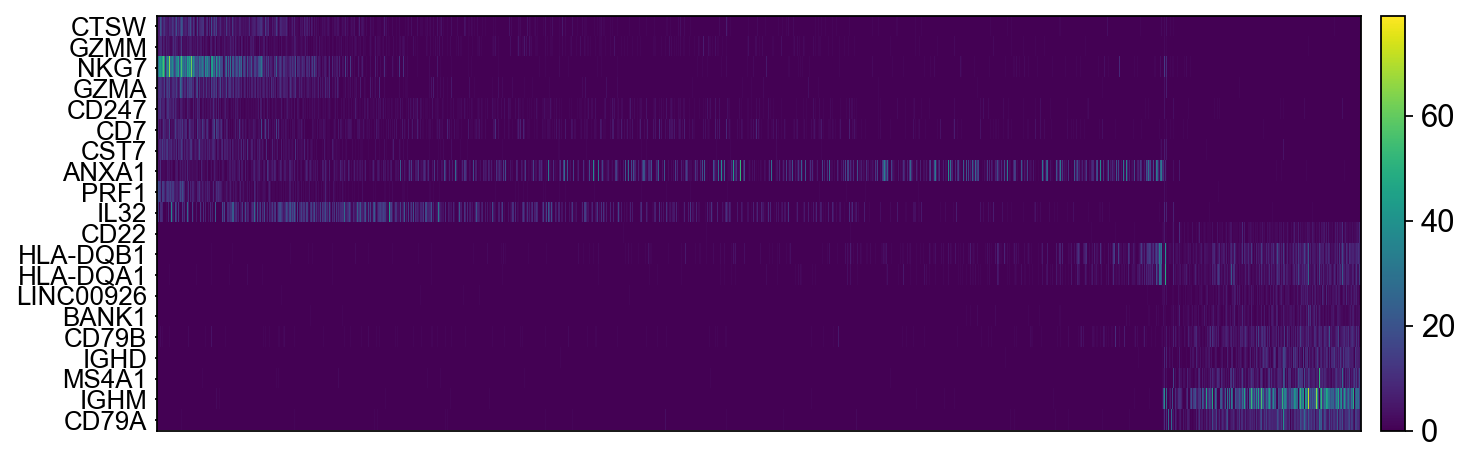

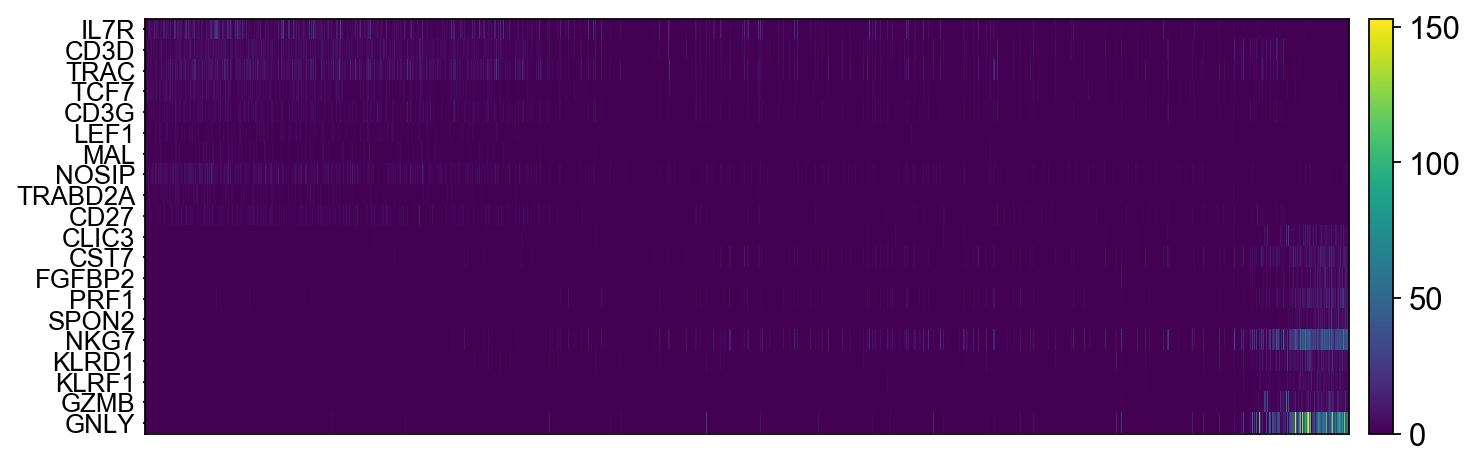

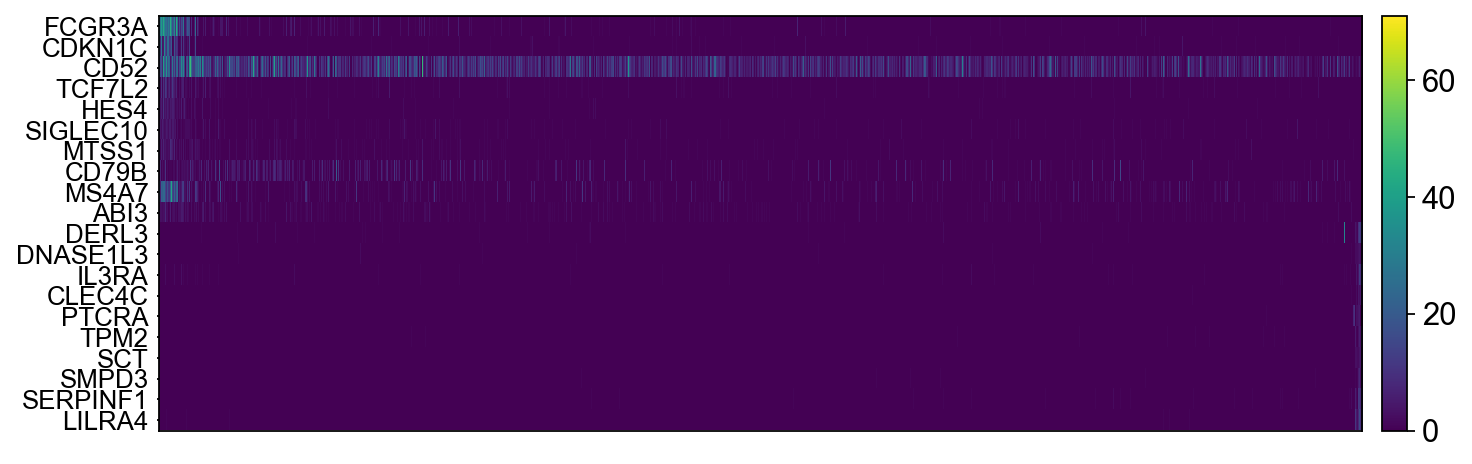

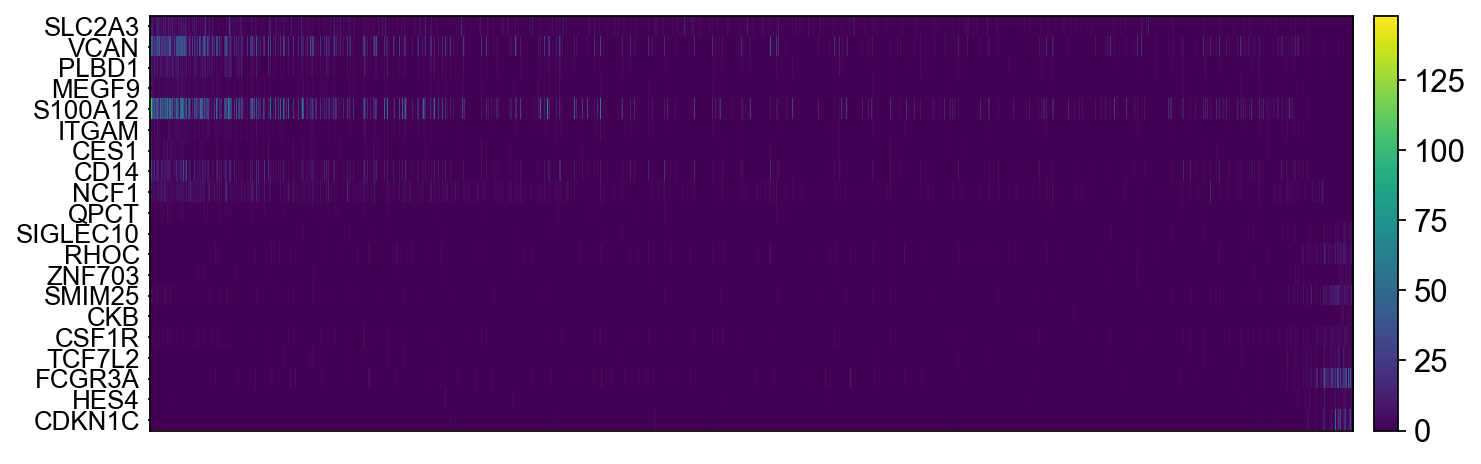

In [10]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

# plot heatmaps of top loading genes? Need to reorder the data in adata.
genes = adata.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), swap_axes = True, use_raw=True)


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

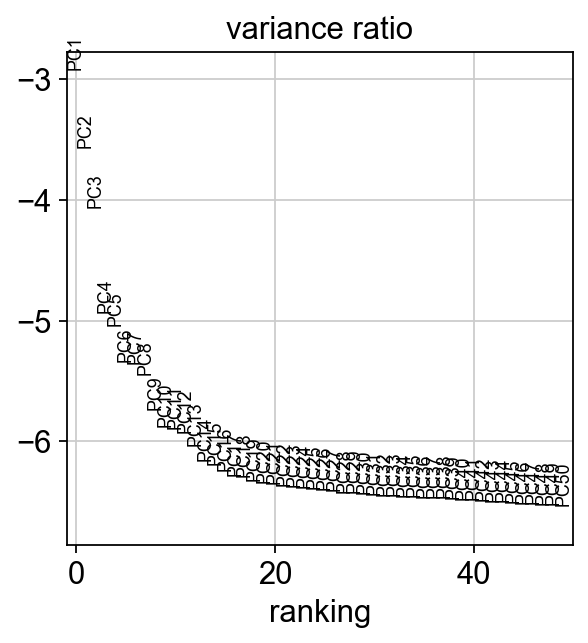

In [11]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Now, we will run pca for the MNN-corrected data instead and compare the results

computing PCA with n_comps = 50
    finished (0:00:00)


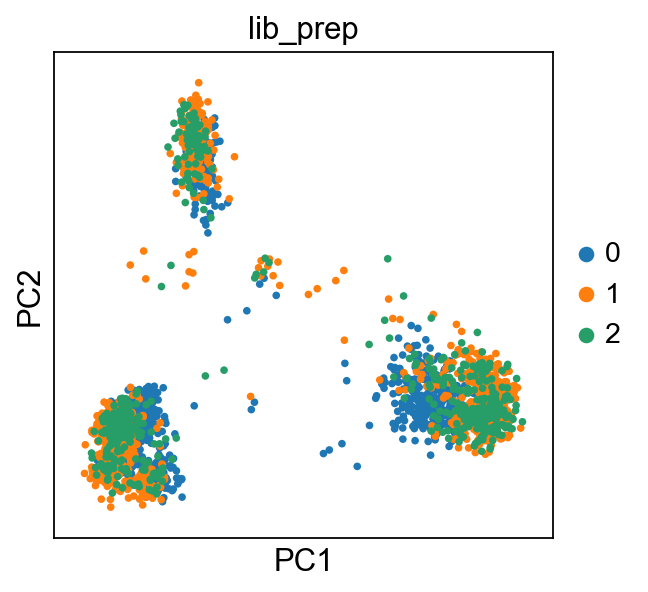

In [12]:
# OBS! Need to run without highly variable genes 
# - since all genes in cdata are highly variable 
# and the slot for variable genes is empty.
sc.tl.pca(cdata, svd_solver='arpack', use_highly_variable = False)

sc.pl.pca(cdata, color='lib_prep')

We still see some separation of the v2 batch towards the middle of the PCA, but less separated than before.

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here, which are 15 neighbors, all PCs (which is 50) and UMAP for calculating neighbors.

The neigbors calculated in this step are used for the UMAP calculation so this step needs to be run before UMAP. 

In [13]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)


In [14]:
sc.pp.neighbors(cdata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


## UMAP

In [15]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06)


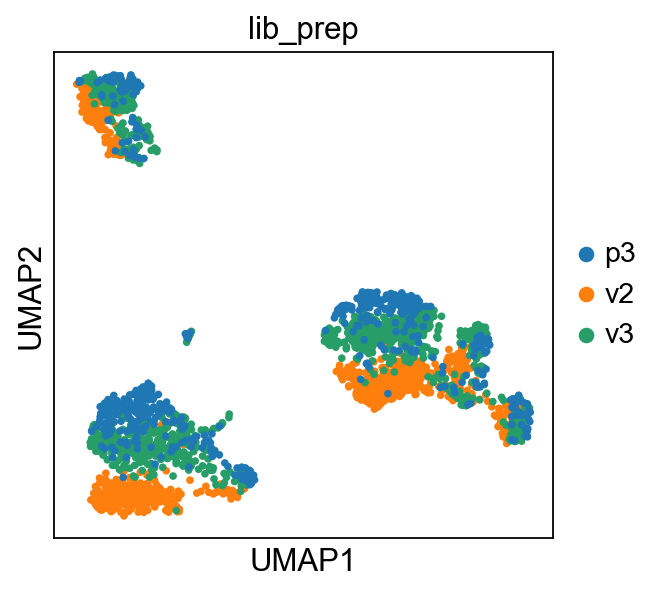

In [16]:
sc.pl.umap(adata, color='lib_prep')

Let's plot some marker genes for different celltypes onto the embedding. The genes are:

* IL7R - CD4 T-cells
* CD8A - CD8 T-cells
* CD14 - CD14 Monocytes
* NKG7 - NK-cells
* FCGR3A - FCGR3A+ Monocytes
* FCER1A - Dendritic cells

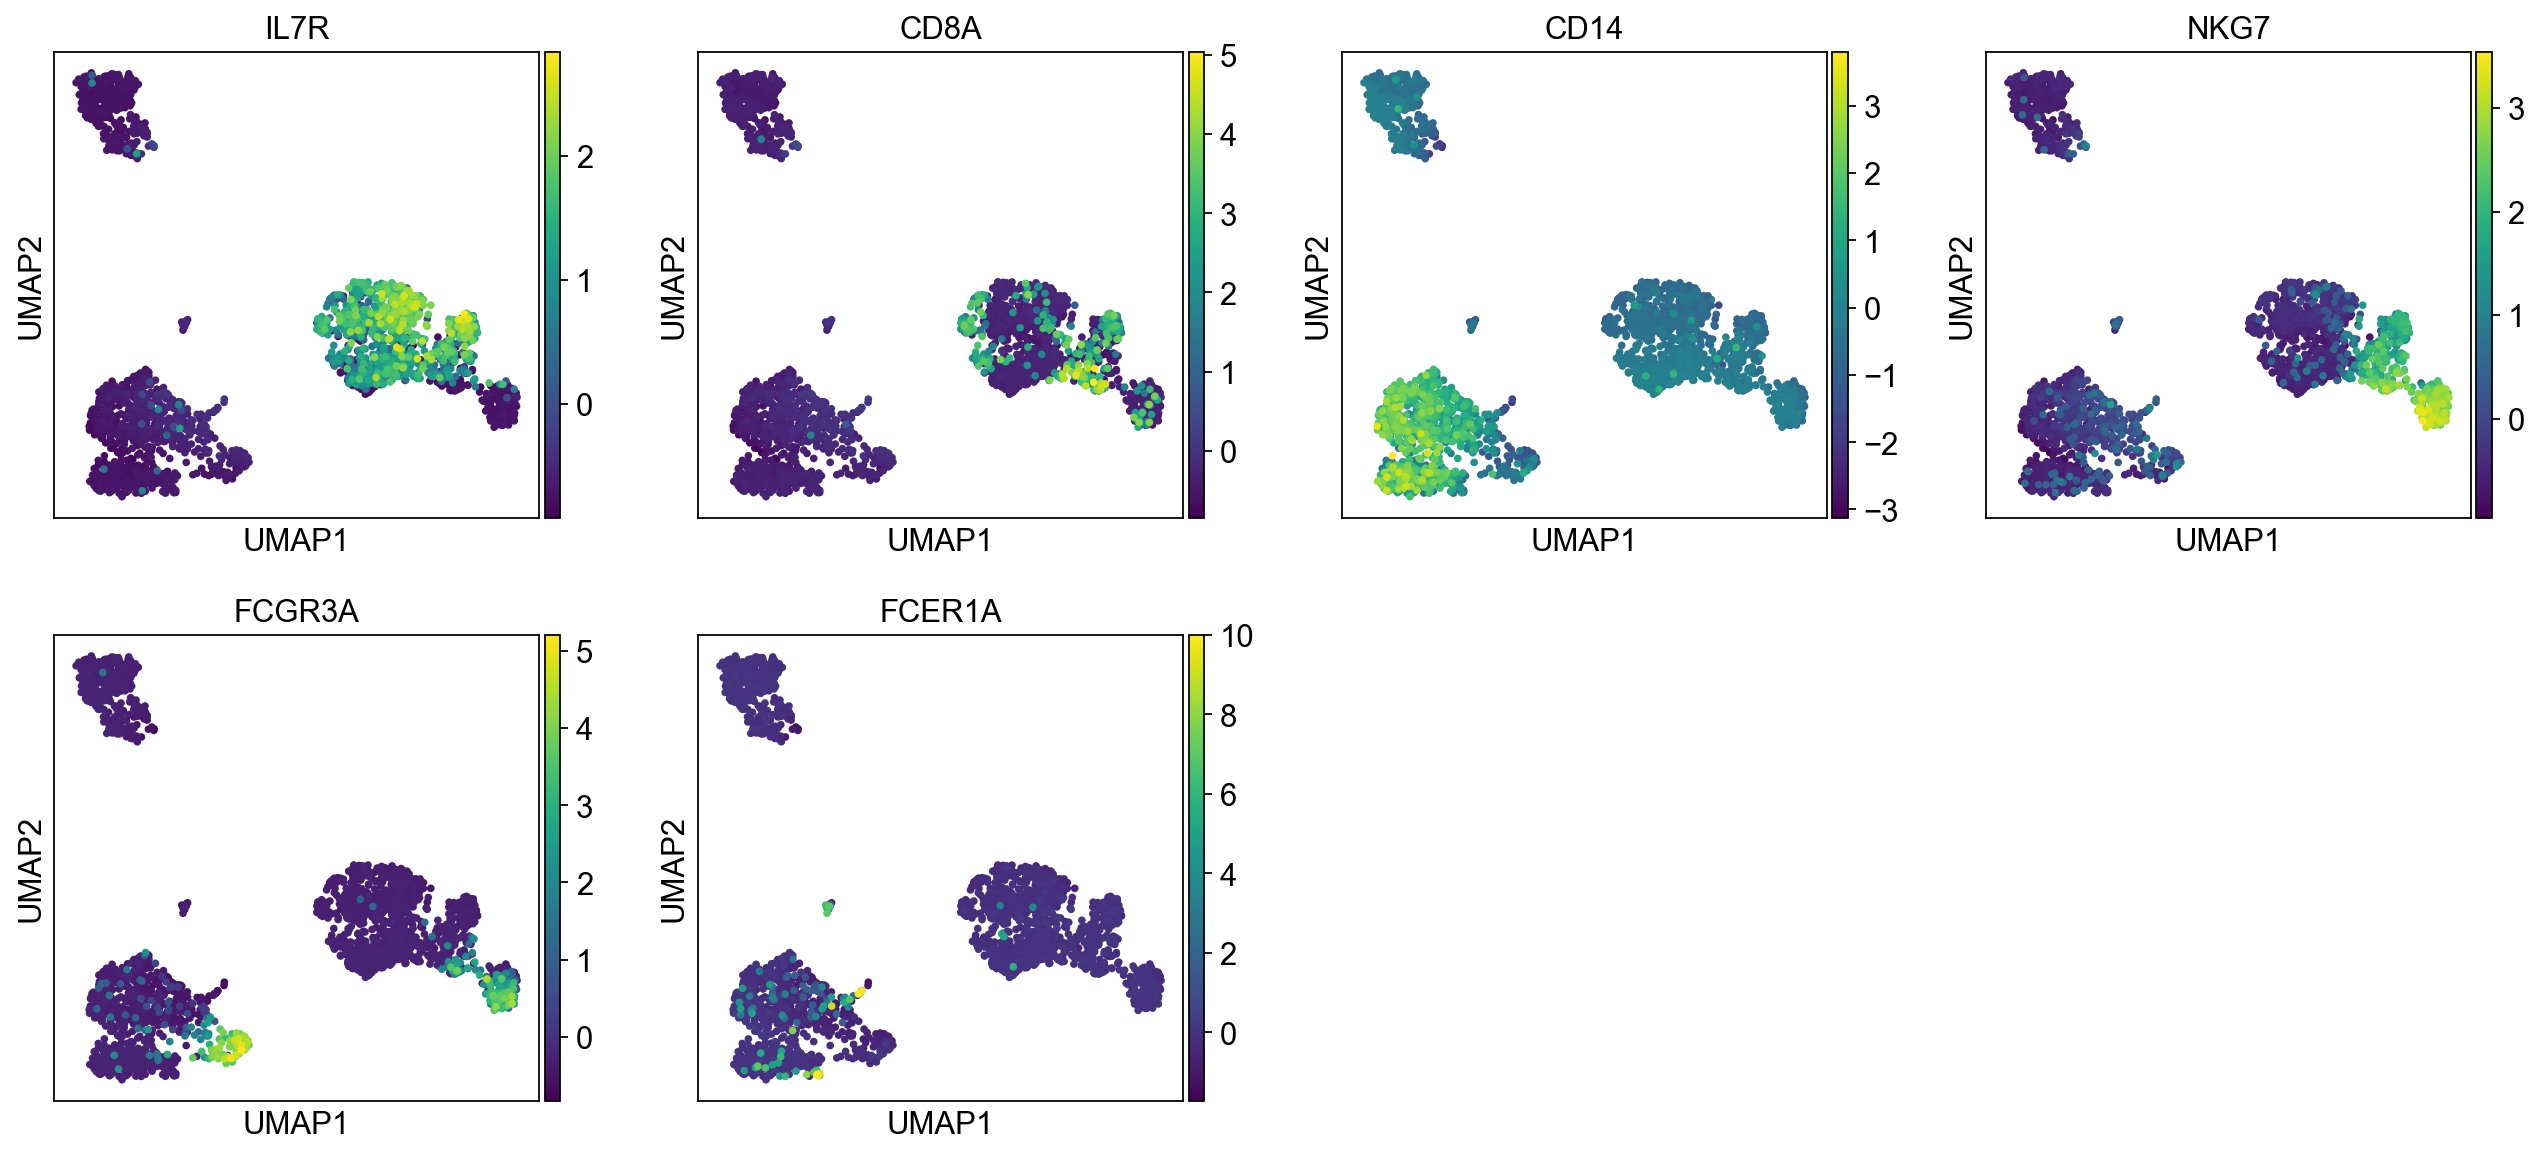

In [17]:
sc.pl.umap(adata, color=['IL7R','CD8A', 'CD14', 'NKG7', 'FCGR3A','FCER1A'], use_raw = False)

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

Same thing for the batch corrected data. 

computing UMAP


/Users/asbj/Programs/miniconda3_4.2.12/envs/scanpy/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:04)


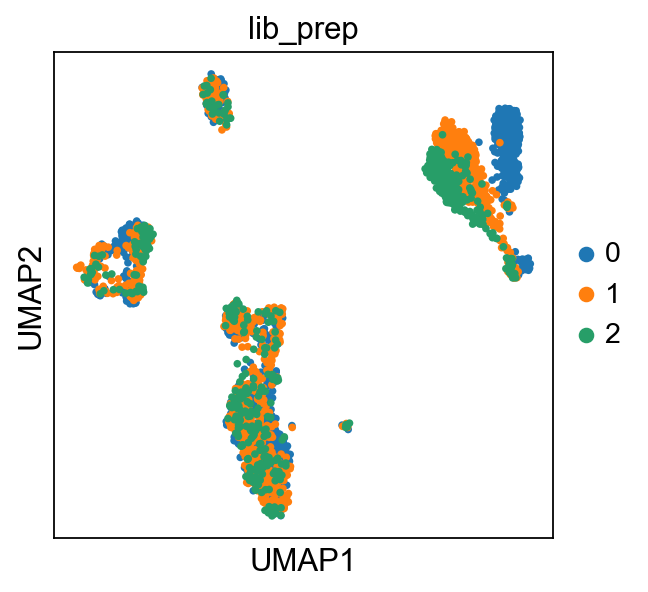

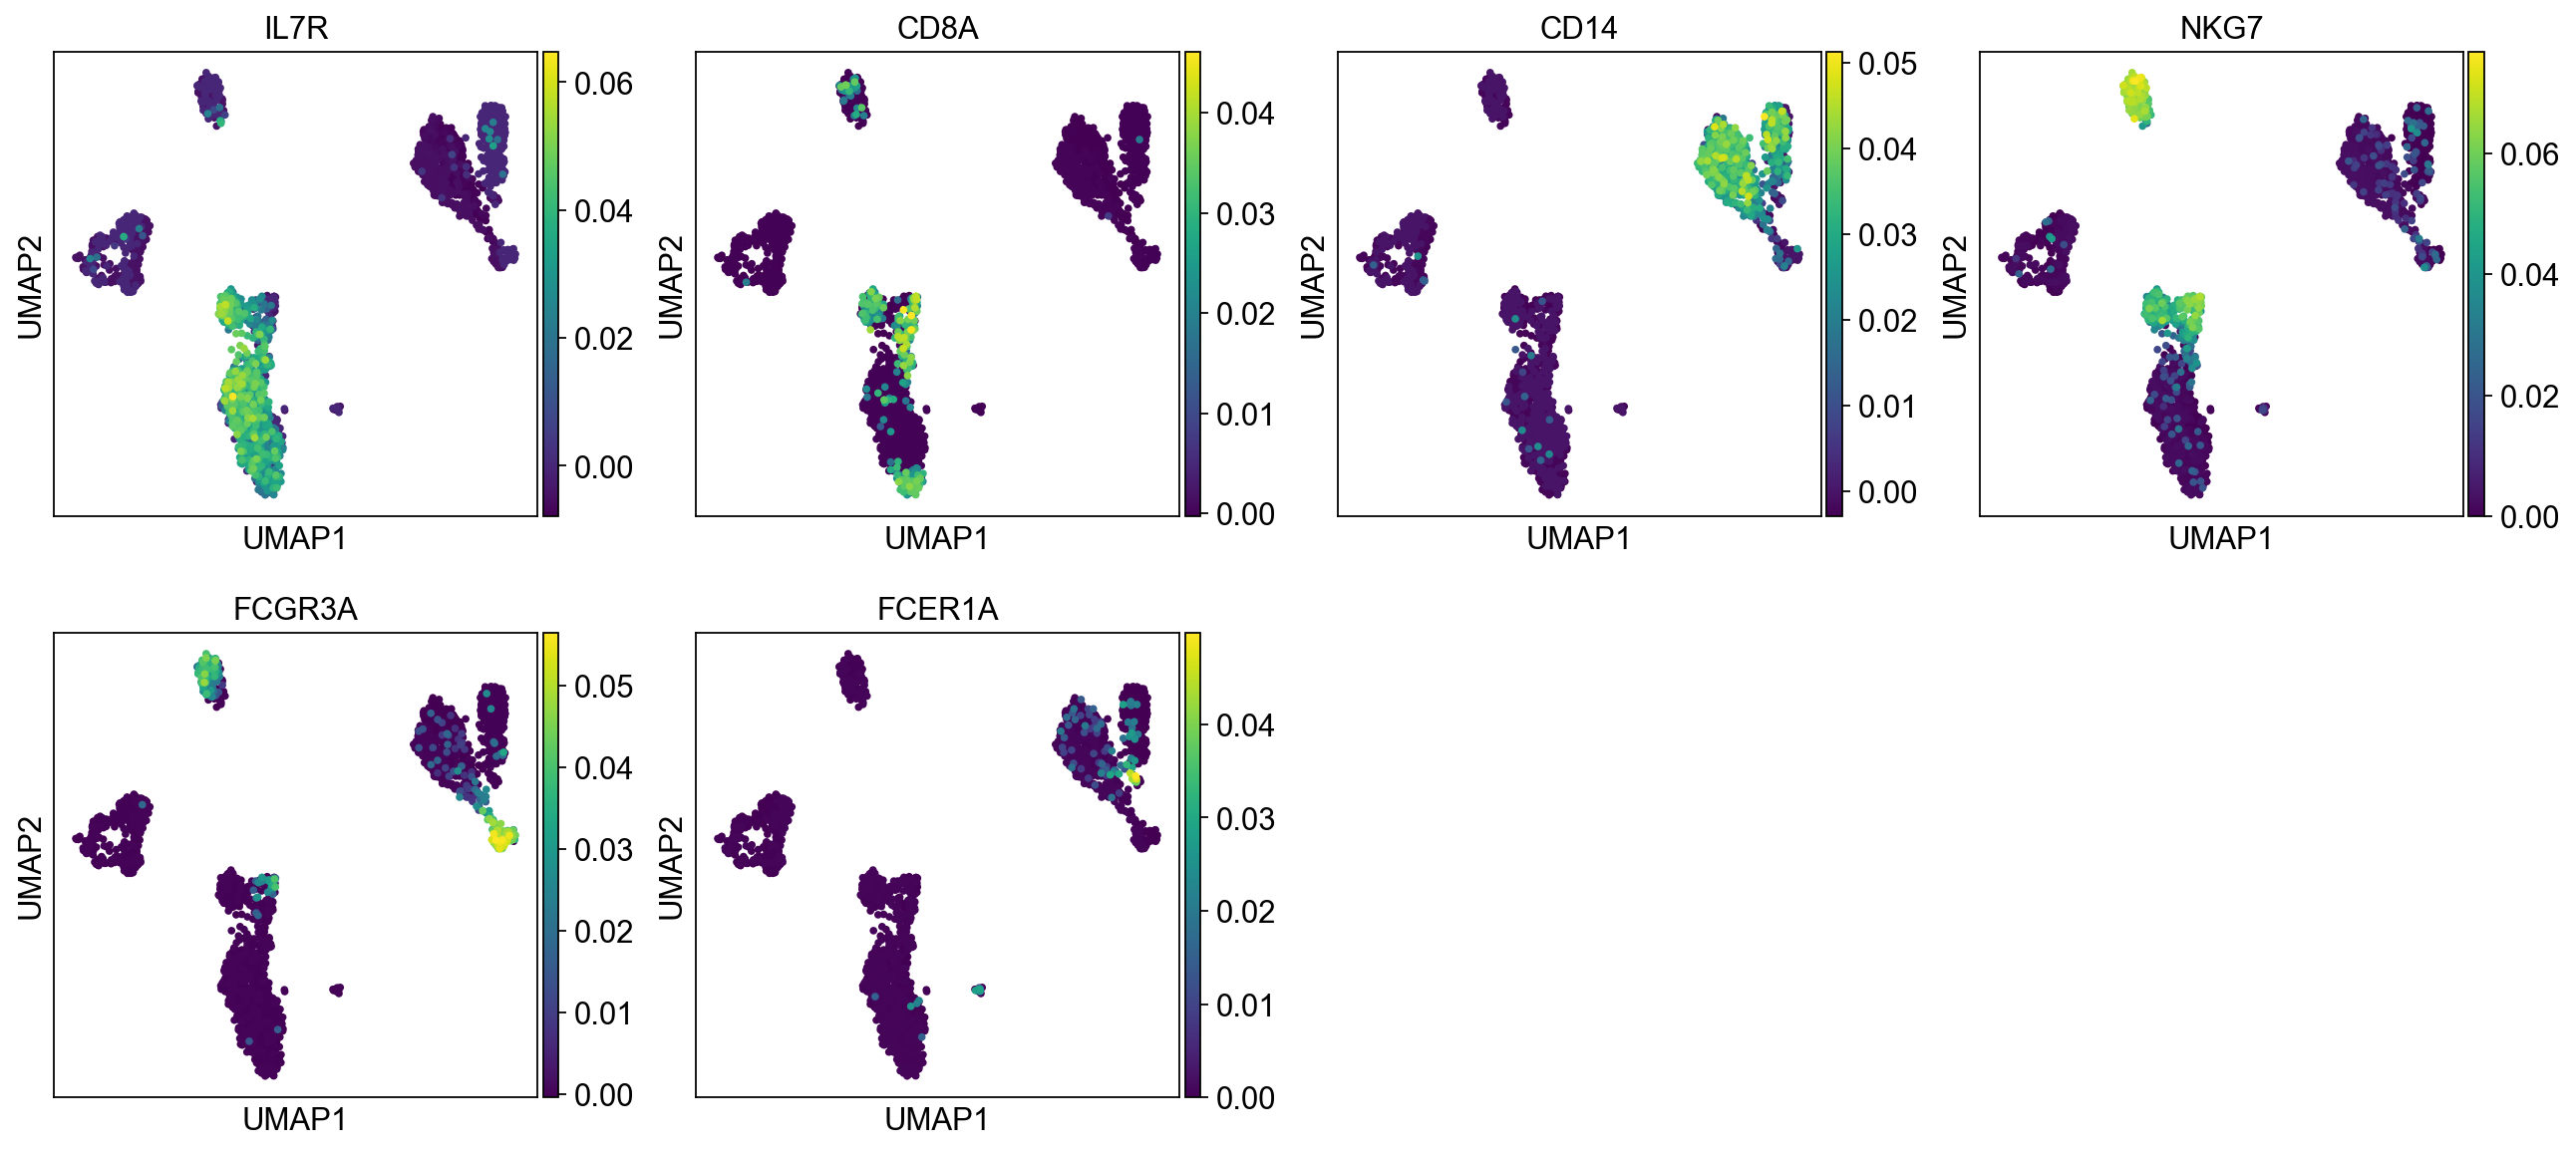

In [18]:
sc.tl.umap(cdata)
sc.pl.umap(cdata, color='lib_prep')
sc.pl.umap(cdata, color=['IL7R','CD8A', 'CD14', 'NKG7', 'FCGR3A','FCER1A'], use_raw=False)

In some populations, like the CD14+ and the FCGR3A+ groups we still have strong separation by batch, while in other groups the integration seems to have worked better.

### tSNE

Run tSNE with same 50 PCs.

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:21)


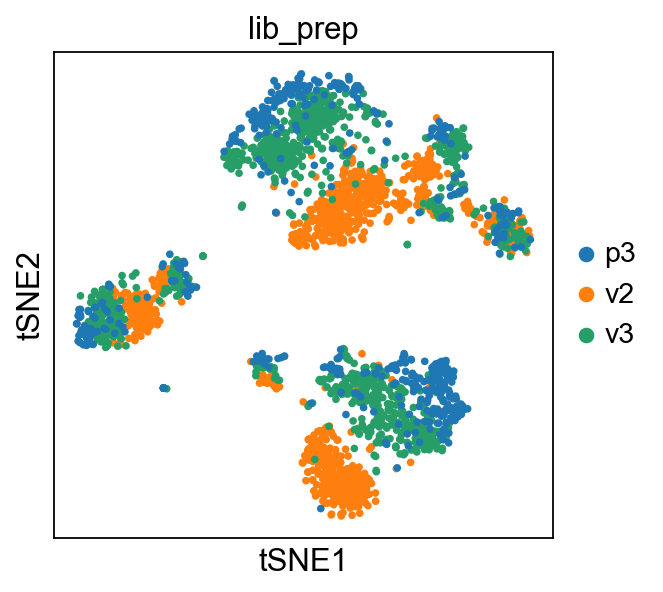

In [19]:
sc.tl.tsne(adata, n_pcs = 50)
sc.pl.tsne(adata, color='lib_prep')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:20)


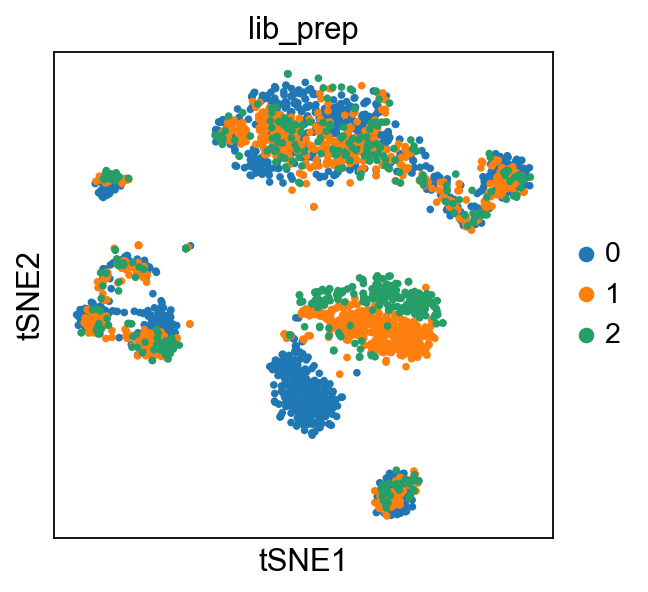

In [20]:
sc.tl.tsne(cdata, n_pcs = 50)
sc.pl.tsne(cdata, color='lib_prep')

### Diffusion map

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9989258  0.9977201  0.98613524 0.98467743 0.983797
     0.9589026  0.9573588  0.9481022  0.9405894  0.9222585  0.91761565
     0.91740173 0.9113995  0.8920167 ]
    finished (0:00:00)


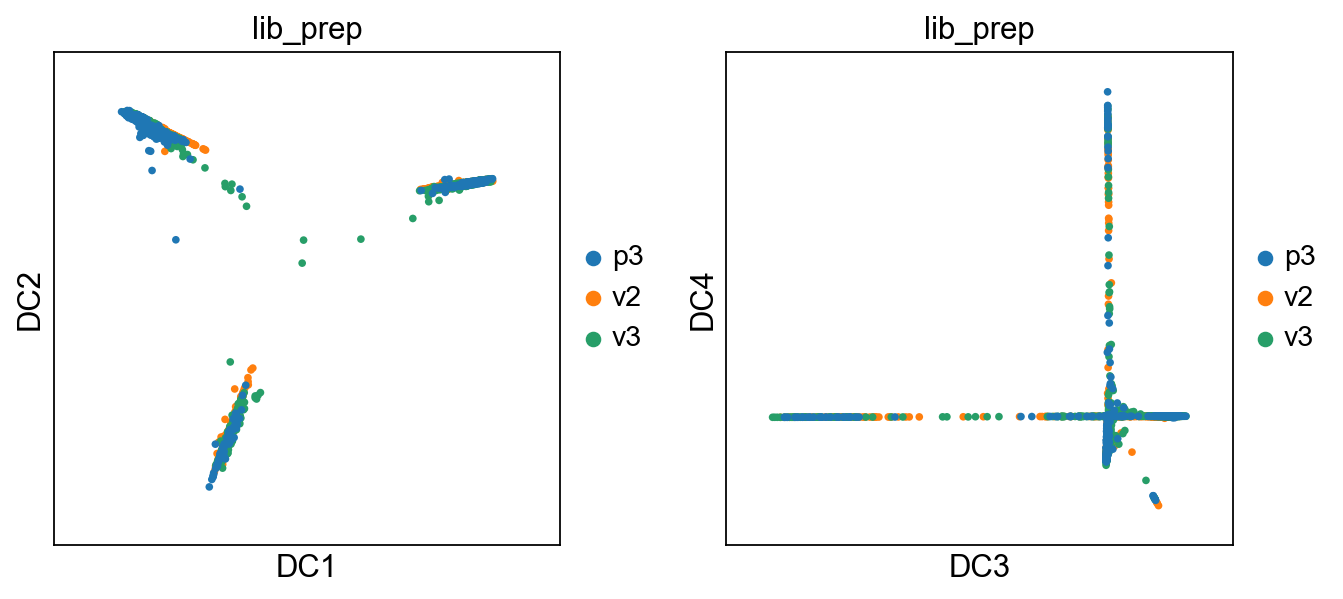

In [21]:
# other dim reductions

sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color='lib_prep', components = ['1,2','3,4'])

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [22]:
sc.tl.louvain(cdata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


Default resolution seems to be 1.0, test a few different values:

In [23]:
sc.tl.louvain(cdata, resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(cdata, resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(cdata, resolution = 1.4, key_added = "louvain_1.4")


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

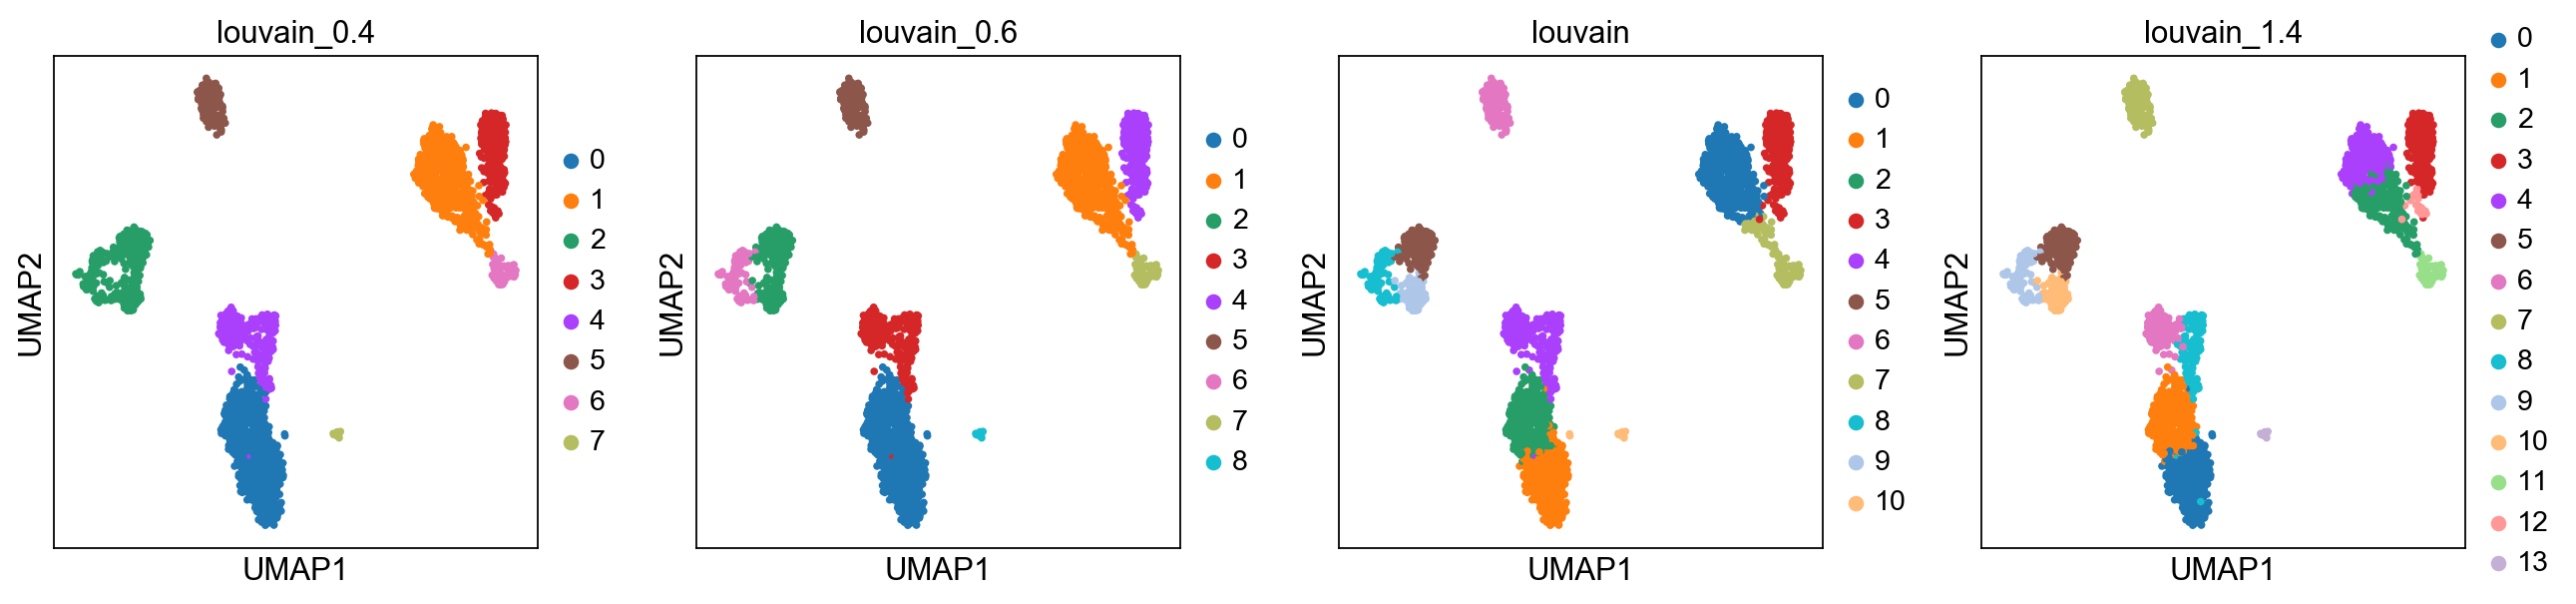

In [24]:
sc.pl.umap(cdata, color=['louvain_0.4', 'louvain_0.6', 'louvain','louvain_1.4'])

Save the result from clustering with batch correction.

In [25]:
cdata.write_h5ad('./../write/scanpy/mnn_corrected_clustered_3pbmc.h5ad')